In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from statistics import mean
from scikitplot.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import logging
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
import pandas as pd
from sklearn.neural_network import MLPClassifier
import time

In [2]:
import logging

# create logger with 'spam_application'
logger = logging.getLogger('spam_application')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('risultati.log')
fh.setLevel(logging.INFO)
logger.addHandler(fh)


In [ ]:
def addestra(nomeDataset, model_class, X, y, iperparametri):
    
    
    model = model_class(**iperparametri)
    model.fit(X, y)

In [3]:
def addestra(nomeDataset, model, X, y, iperparametri):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=30, stratify=y)
    
    #standardizzo i dati
    sc = StandardScaler()
    X_train_standardizzato = sc.fit_transform(X_train)
    X_test_standardizzato = sc.fit_transform(X_test)
    
    #applico la riduzione della dimensionalita'
    pca = PCA(n_components = iperparametri['dim'])
    
    X_train_ridotto = pca.fit_transform(X_train_standardizzato)
    X_test_ridotto = pca.fit_transform(X_test_standardizzato)
    
    if model == SVC:
        #addestro la SVC
        modelSVC = SVC(gamma = iperparametri['gamma'], C=iperparametri['C'], kernel = iperparametri['kernel'])
        modelSVC.fit(X_train_ridotto, y_train)
        
        y_pred = modelSVC.predict(X_test_ridotto)
        
    elif model == DecisionTreeClassifier:
        #addestro il DecisionTreeClassifier
        modelDecTree = DecisionTreeClassifier(criterion= iperparametri['criterio'])
        modelDecTree.fit(X_train_ridotto, y_train)
        
        y_pred = modelDecTree.predict(X_test_ridotto)
        
    elif model == RandomForestClassifier:
        #addestro il RandomForestClassifier
        modelRanForest = RandomForestClassifier(n_estimators = iperparametri['n_estimators'])
        modelRanForest.fit(X_train_ridotto, y_train)
    
        y_pred = modelRanForest.predict(X_test_ridotto)
        
    elif model == LinearDiscriminantAnalysis:
        #addestro il LinearDiscriminantAnalysis
        modelLin = LinearDiscriminantAnalysis(solver = iperparametri['solver'])
        modelLin.fit(X_train_ridotto, y_train)

        y_pred = modelLin.predict(X_test_ridotto)
        
    elif model == MLPClassifier:
        #addestro il MLPClassifier
        modelMLP = MLPClassifier(hidden_layer_sizes = iperparametri['hidden_layer_sizes'], momentum = iperparametri['momentum'], learning_rate = iperparametri['learning_rate'], learning_rate_init = iperparametri['learning_rate_init'], max_iter = iperparametri['max_iter'], activation = iperparametri['activation'])
        modelMLP.fit(X_train_ridotto, y_train)
    
        y_pred = modelMLP.predict(X_test_ridotto)     
    
    elif model == GaussianNB:
        #addestro il GaussianNB
        modelG = GaussianNB()
        modelG.fit(X_train_ridotto, y_train)
        
        y_pred = modelG.predict(X_test_ridotto)     
        
    #calcolo lo score
    scoreStandardizzato = accuracy_score(y_test, y_pred)
    

    plot_confusion_matrix(y_test, y_pred)
    plt.show()
    #logger.info(f'Addestrato {nomeDataset} standardizzando i dati con una SVC con uno score di {scoreStandardizzato} e iperparametri: C {c}, gamma {gamma}, kernel {kernel}, numero dimensioni {dim}')
    return(f'Lo score e stato calcolato standardizzando i dati, score: {scoreStandardizzato}')


def trovaIperparametri(X, y, model, numero_dimensioni):
    
    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30, stratify=y)

    if model == SVC:
        steps = [
            ('scaler', StandardScaler()),
            ('reduce_dim', PCA()),
            ('SVM', SVC()), 
        ]

        pipeline = Pipeline(steps)

        valori_C = np.arange(0.1, 1.0, 0.1)
        valori_gamma = [0.1, 0.01]
        valori_kernel = ['linear', 'poly', 'rbf', 'sigmoid']

        params = { 'SVM__C': valori_C,
                  'SVM__gamma': valori_gamma,
                  'SVM__kernel': valori_kernel,
                  'reduce_dim__n_components': np.arange(1, numero_dimensioni, 1),
                }
    elif model == DecisionTreeClassifier:
        
        steps = [
            ('scaler', StandardScaler()),
            ('reduce_dim', PCA()),
            ('tree', DecisionTreeClassifier()),
        ]
        
        pipeline= Pipeline(steps)
        
        params = {'reduce_dim__n_components': np.arange(1, numero_dimensioni, 1),
                  'tree__criterion': ['gini', 'entropy'],
                 }
    
    elif model == RandomForestClassifier:
        
        steps = [
            ('scaler', StandardScaler()),
            ('reduce_dim', PCA()),
            ('random_forest', RandomForestClassifier()),
        ]
        
        pipeline = Pipeline(steps)
        
        params = {'reduce_dim__n_components': np.arange(1, numero_dimensioni, 1),
                  'random_forest__n_estimators': np.arange(10, 100, 10),
                 }
    
    elif model == LinearDiscriminantAnalysis:
        
        steps = [
            ('scaler', StandardScaler()),
            ('reduce_dim', PCA()),
            ('linear_discriminant_analysis', LinearDiscriminantAnalysis()),
        ]
        
        pipeline = Pipeline(steps)
        
        params = {'reduce_dim__n_components': np.arange(1, numero_dimensioni, 1),
                  'linear_discriminant_analysis__solver': ['svd', 'lsqr', 'eigen'],
                  
                 }
    elif model == GaussianNB:
        steps = [
            ('scaler', StandardScaler()),
            ('reduce_dim', PCA()),
            ('linear_discriminant_analysis', LinearDiscriminantAnalysis()),
        ]
        
        pipeline = Pipeline(steps)
        
        params = {'reduce_dim__n_components': np.arange(1, numero_dimensioni, 1),

                 }
        
    elif model == MLPClassifier:  
        
        steps = [
            ('scaler', StandardScaler()),
            ('reduce_dim', PCA()),
            ('mlpClassifier', MLPClassifier()), 
        ]
        
        pipeline = Pipeline(steps)
        
        params = {'reduce_dim__n_components': np.arange(1, numero_dimensioni, 1),
                  'mlpClassifier__learning_rate': ['constant', 'invscaling', 'adaptive'],
                  'mlpClassifier__learning_rate_init' : [0.0001, 0.001, 0.01],
                  'mlpClassifier__activation' : ['relu', 'logistic'],
                  
                 }
        
    grid = GridSearchCV(pipeline, param_grid=params, cv=3)
    
    grid.fit(X_train, y_train)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    return grid.best_params_

In [4]:
dataset = pd.read_excel('IncidentiModificato.xlsx', sheet_name='Foglio1', index_col=0)

In [5]:
dataset

,DATA,SESSO,ANNI,PESO,ALTEZZA,BMI,Mezzo,Testa:Neurocranio,Testa: Splancnocranio,Testa: Telencefalo,...,Scheletro: Rachide cervicale,Scheletro: Rachide toracico,Scheletro: Rachide lombare,Scheletro: Bacino e sacro,Scheletro: Complesso sterno/claveo/costale,Tot Testa,Tot Torace,Tot Addome,Tot Scheletro,Totale
VERBALE,,,,,,,,,,,,,,,,,,,,,
85567,1999-10-29,0,81,84.0,1.75,27.428571,0,1,0,0,...,0,3,0,3,3,2,0,3,9,14
85829,2000-01-14,1,69,69.0,1.62,26.291724,1,4,4,4,...,0,0,0,0,4,20,7,1,4,32
85977,2000-03-10,1,71,67.0,1.55,27.887617,1,2,0,1,...,0,0,0,0,4,6,0,0,4,10
86220,2000-06-14,1,54,60.0,1.59,23.733238,1,4,0,0,...,0,0,0,0,4,5,3,2,4,14
86247,2000-06-22,1,78,69.0,1.67,24.740937,1,2,0,0,...,0,0,0,0,4,2,0,2,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101618,2019-05-08,1,82,80.2,1.62,30.559366,0,1,0,0,...,0,0,0,0,0,1,2,0,0,3
101288E,2018-11-07,1,70,75.6,1.57,30.670615,0,2,0,0,...,0,0,0,0,3,2,0,0,3,5
E-97586,2013-05-14,0,45,45.0,1.77,14.363689,1,0,0,0,...,0,0,0,4,4,0,1,0,8,9


In [6]:
datasetTotali = dataset[['DATA', 'SESSO', 'Mezzo', 'PESO', 'ALTEZZA', 'BMI', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro', 'Totale']]
datasetTotali

,DATA,SESSO,Mezzo,PESO,ALTEZZA,BMI,Tot Testa,Tot Torace,Tot Addome,Tot Scheletro,Totale
VERBALE,,,,,,,,,,,
85567,1999-10-29,0,0,84.0,1.75,27.428571,2,0,3,9,14
85829,2000-01-14,1,1,69.0,1.62,26.291724,20,7,1,4,32
85977,2000-03-10,1,1,67.0,1.55,27.887617,6,0,0,4,10
86220,2000-06-14,1,1,60.0,1.59,23.733238,5,3,2,4,14
86247,2000-06-22,1,1,69.0,1.67,24.740937,2,0,2,4,8
...,...,...,...,...,...,...,...,...,...,...,...
101618,2019-05-08,1,0,80.2,1.62,30.559366,1,2,0,0,3
101288E,2018-11-07,1,0,75.6,1.57,30.670615,2,0,0,3,5
E-97586,2013-05-14,0,1,45.0,1.77,14.363689,0,1,0,8,9


In [7]:
#Dataframe con X senza Mezzo e senza la data
# y solo mezzo
Xtotale = datasetTotali.drop('Mezzo', 1)
ytotale = datasetTotali['Mezzo']
Xtotale = Xtotale.drop('DATA', 1)

In [8]:
Xtotale.shape


(130, 9)

In [9]:
trovaIperparametri(model=MLPClassifier, numero_dimensioni=9, X=Xtotale, y=ytotale)

--- 35.352459192276 seconds ---


{'mlpClassifier__activation': 'relu',
 'mlpClassifier__learning_rate': 'adaptive',
 'mlpClassifier__learning_rate_init': 0.001,
 'reduce_dim__n_components': 1}

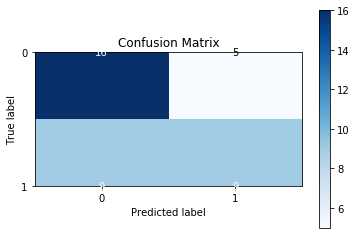

'Lo score e stato calcolato standardizzando i dati, score: 0.6410256410256411'

In [10]:
#addestro usando due livelli da 50
addestra(nomeDataset='Incidenti',model=MLPClassifier, X=Xtotale, y=ytotale,iperparametri={'activation':'relu', 'learning_rate':'adaptive', 'learning_rate_init':0.0001, 'dim':6, 'max_iter':500, 'momentum':1, 'hidden_layer_sizes':(50, 50)})

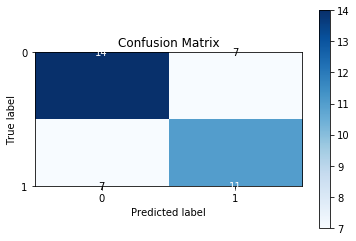

'Lo score e stato calcolato standardizzando i dati, score: 0.6410256410256411'

In [11]:
addestra(nomeDataset='Incidenti', model=MLPClassifier, X=Xtotale, y=ytotale, iperparametri={'activation':'relu', 'learning_rate':'constant', 'learning_rate_init':0.0001, 'dim':9, 'max_iter':500, 'momentum':1, 'hidden_layer_sizes':(50, 50)})

In [12]:
#trovo iperparametri per una SVC

trovaIperparametri(model=SVC, X=Xtotale, y=ytotale, numero_dimensioni=9)

--- 8.413557291030884 seconds ---


{'SVM__C': 0.7000000000000001,
 'SVM__gamma': 0.1,
 'SVM__kernel': 'sigmoid',
 'reduce_dim__n_components': 1}

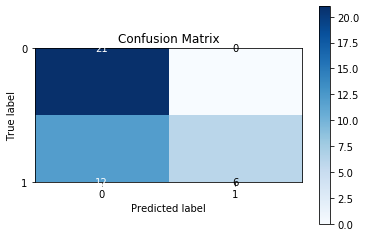

'Lo score e stato calcolato standardizzando i dati, score: 0.6923076923076923'

In [13]:
addestra(nomeDataset='Incidenti', model=SVC, X=Xtotale, y=ytotale, iperparametri={'C':0.7, 'gamma':0.1, 'kernel':'sigmoid', 'dim':1})

In [14]:
#trovo iperparametri per un randomForest
trovaIperparametri(model=RandomForestClassifier, X=Xtotale, y=ytotale, numero_dimensioni=9)

--- 11.88661003112793 seconds ---


{'random_forest__n_estimators': 80, 'reduce_dim__n_components': 7}

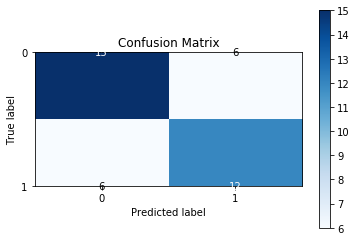

'Lo score e stato calcolato standardizzando i dati, score: 0.6923076923076923'

In [15]:
addestra(nomeDataset='Incidenti',model=RandomForestClassifier, X=Xtotale, y=ytotale,iperparametri={'n_estimators':40, 'dim':6})

In [16]:
trovaIperparametri(model=DecisionTreeClassifier, X=Xtotale, y=ytotale, numero_dimensioni=9)

--- 0.23594951629638672 seconds ---


{'reduce_dim__n_components': 8, 'tree__criterion': 'gini'}

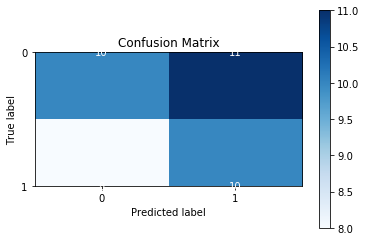

'Lo score e stato calcolato standardizzando i dati, score: 0.5128205128205128'

In [17]:
addestra(nomeDataset='Incidenti',model=DecisionTreeClassifier, X=Xtotale, y=ytotale,iperparametri={'criterio':'gini', 'dim':6})

In [18]:
trovaIperparametri(model=LinearDiscriminantAnalysis, X=Xtotale, y=ytotale, numero_dimensioni=9)

--- 0.3780517578125 seconds ---


{'linear_discriminant_analysis__solver': 'svd', 'reduce_dim__n_components': 1}

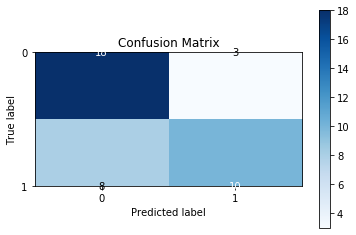

'Lo score e stato calcolato standardizzando i dati, score: 0.717948717948718'

In [19]:
addestra(nomeDataset='Incidenti',model=LinearDiscriminantAnalysis,  X=Xtotale, y=ytotale, iperparametri={'solver':'svd', 'dim':1})

In [20]:
trovaIperparametri(model=GaussianNB, X=Xtotale, y=ytotale, numero_dimensioni=9)

--- 0.12740159034729004 seconds ---


{'reduce_dim__n_components': 1}

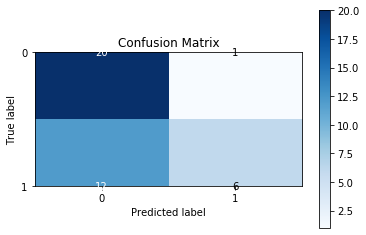

'Lo score e stato calcolato standardizzando i dati, score: 0.6666666666666666'

In [21]:
addestra(nomeDataset='Incidenti', model=GaussianNB, X=Xtotale, y=ytotale, iperparametri={'dim':1})

In [22]:
#usando solo i totali il modello con le maggiori prestazioni è LinearDiscriminantAnalysis con un punteggio di 0.71
#segue SVC con circa 0.69

In [23]:
#Uso piu dettaglio
#Dataframe con X senza Mezzo e senza la data
# y solo mezzo
Xdettagli = dataset.drop('Mezzo', 1)
ydettagli = dataset['Mezzo']
Xdettagli = Xdettagli.drop('DATA', 1)
Xdettagli

,SESSO,ANNI,PESO,ALTEZZA,BMI,Testa:Neurocranio,Testa: Splancnocranio,Testa: Telencefalo,Testa: Cervelletto,Testa:Tronco encefalico,...,Scheletro: Rachide cervicale,Scheletro: Rachide toracico,Scheletro: Rachide lombare,Scheletro: Bacino e sacro,Scheletro: Complesso sterno/claveo/costale,Tot Testa,Tot Torace,Tot Addome,Tot Scheletro,Totale
VERBALE,,,,,,,,,,,,,,,,,,,,,
85567,0,81,84.0,1.75,27.428571,1,0,0,0,1,...,0,3,0,3,3,2,0,3,9,14
85829,1,69,69.0,1.62,26.291724,4,4,4,4,4,...,0,0,0,0,4,20,7,1,4,32
85977,1,71,67.0,1.55,27.887617,2,0,1,1,2,...,0,0,0,0,4,6,0,0,4,10
86220,1,54,60.0,1.59,23.733238,4,0,0,1,0,...,0,0,0,0,4,5,3,2,4,14
86247,1,78,69.0,1.67,24.740937,2,0,0,0,0,...,0,0,0,0,4,2,0,2,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101618,1,82,80.2,1.62,30.559366,1,0,0,0,0,...,0,0,0,0,0,1,2,0,0,3
101288E,1,70,75.6,1.57,30.670615,2,0,0,0,0,...,0,0,0,0,3,2,0,0,3,5
E-97586,0,45,45.0,1.77,14.363689,0,0,0,0,0,...,0,0,0,4,4,0,1,0,8,9


In [24]:
Xdettagli.shape

(130, 30)

In [25]:
trovaIperparametri(model=MLPClassifier, numero_dimensioni=30, X=Xdettagli, y=ydettagli)

--- 158.24504232406616 seconds ---


{'mlpClassifier__activation': 'relu',
 'mlpClassifier__learning_rate': 'constant',
 'mlpClassifier__learning_rate_init': 0.0001,
 'reduce_dim__n_components': 16}

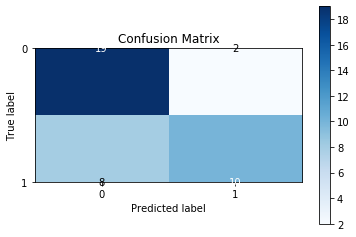

'Lo score e stato calcolato standardizzando i dati, score: 0.7435897435897436'

In [26]:
#addestro usando due livelli da 50

addestra(nomeDataset='Incidenti',model=MLPClassifier, X=Xdettagli, y=ydettagli, iperparametri={'activation':'relu', 'learning_rate':'constant', 'learning_rate_init':0.001, 'dim':1, 'max_iter':500, 'momentum':1, 'hidden_layer_sizes':(50, 50)})

In [27]:
#trovo iperparametri per una SVC

trovaIperparametri(model=SVC, X=Xdettagli, y=ydettagli, numero_dimensioni=30)

--- 34.438016176223755 seconds ---


{'SVM__C': 0.7000000000000001,
 'SVM__gamma': 0.1,
 'SVM__kernel': 'linear',
 'reduce_dim__n_components': 22}

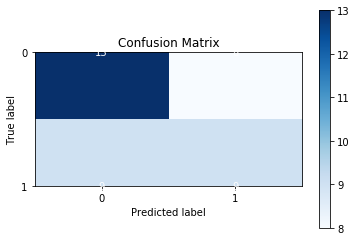

'Lo score e stato calcolato standardizzando i dati, score: 0.5641025641025641'

In [28]:
#addestro una SVC
addestra(nomeDataset='Incidenti',model=SVC, X=Xdettagli, y=ydettagli, iperparametri={'C':0.7, 'gamma':0.1, 'kernel':'linear', 'dim':22})

In [29]:
#trovo iperparametri per un randomForest
trovaIperparametri(model=RandomForestClassifier, X=Xdettagli, y=ydettagli, numero_dimensioni=30)

--- 44.15233492851257 seconds ---


{'random_forest__n_estimators': 90, 'reduce_dim__n_components': 20}

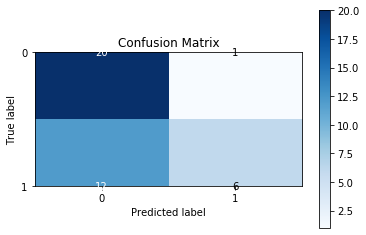

'Lo score e stato calcolato standardizzando i dati, score: 0.6666666666666666'

In [30]:
#addestra un randomForest
addestra(nomeDataset='Incidenti',model=RandomForestClassifier, X=Xdettagli, y=ydettagli, iperparametri={'n_estimators':80, 'dim':19})

In [31]:
#cerco gli iperparametri per un LinearDiscriminantAnalysis
trovaIperparametri(model=LinearDiscriminantAnalysis, X=Xdettagli, y=ydettagli, numero_dimensioni=30)

--- 1.4766349792480469 seconds ---


{'linear_discriminant_analysis__solver': 'svd', 'reduce_dim__n_components': 1}

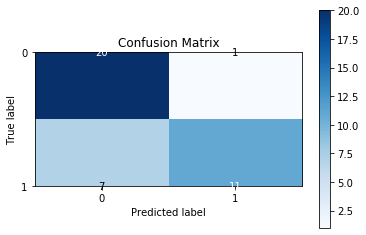

'Lo score e stato calcolato standardizzando i dati, score: 0.7948717948717948'

In [32]:
#addestra un LinearDiscriminantAnalysis#
addestra(nomeDataset='Incidenti', model=LinearDiscriminantAnalysis, X=Xdettagli, y=ydettagli, iperparametri={'solver':'svd' , 'dim':1})

In [33]:
#trovo iperparametri per un GaussianNB
trovaIperparametri(model=GaussianNB, X=Xtotale, y=ytotale, numero_dimensioni=9)

--- 0.13291621208190918 seconds ---


{'reduce_dim__n_components': 1}

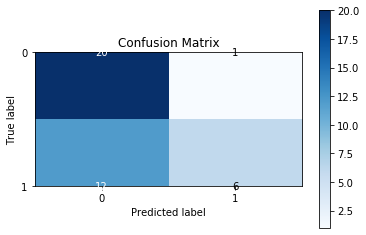

'Lo score e stato calcolato standardizzando i dati, score: 0.6666666666666666'

In [34]:
#addestra un GaussianNB
addestra(nomeDataset='prova', model=GaussianNB, X=Xtotale, y=ytotale, iperparametri={'dim':1})

In [35]:
#i modelli con le maggiori prestazioni sono MLP ma impiega assai a trovare gli iperparametri e LinearDiscriminantAnalysis